# Movie recommendations engine

#### Objective:
Using IMDB movie database, recommend 5 popular movies to a user typing 1 movie as input

Note: no collaborative filtering, not having users data

In [1]:
# Data and libraries loading

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
sns.set()
import warnings; warnings.simplefilter('ignore')

raw = pd.read_csv('MovieDB_post_cleaning.csv',
                  low_memory= False,
                  index_col = 0,
                  na_filter = False)
data = raw.copy()
data.shape

C:\Users\Fox\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


(4911, 15)

## Data Encoding

In [2]:
# ENCODING: GENRES

df_dummies = data['genres'].str.get_dummies(sep='|')
df_dummies = df_dummies.add_prefix('genre_')
X = pd.concat([df_dummies, data], axis=1)
X.shape

(4911, 42)

In [3]:
# ENCODING: DIRECTOR_NAME

df_dummies = pd.get_dummies(X['director_name'], prefix='director_name')
X = pd.concat([df_dummies, X], axis=1)
X.shape

(4911, 2439)

In [4]:
# THRESHOLD DETERMINATION: DIRECTOR_NAME

d = {}
for seuil in range(15,2,-2): # Seuil = nombre de films par directeur
    d[seuil] = (X['director_name'].value_counts()[X['director_name'].value_counts()>=seuil].count(), # Nombre de directeurs concernés
                X['director_name'].value_counts()[X['director_name'].value_counts()>=seuil].sum()) # Nombre de lignes concernées par ces directeurs
df = pd.DataFrame(d).T.reset_index()
df.columns = ['Seuil: nb de films','Nb de directeur atteignant ce seuil','Nb de films concernés']
df.T

# Gardant seulement les directeurs avec 3 films minimum, on crée 512 features.

,0,1,2,3,4,5,6
Seuil: nb de films,15,13,11,9,7,5,3
Nb de directeur atteignant ce seuil,9,16,27,42,95,215,512
Nb de films concernés,246,339,464,606,1001,1647,2662


In [5]:
# THRESHOLD FILTERING: DIRECTOR_NAME

seuil = 2
mask = list(X['director_name'].value_counts()[X['director_name'].value_counts()>seuil].index) # Les directeurs à garder
mask = list(filter(None, mask)) # Suppression la valeur "" 
L = list(df_dummies.columns) # Tous les directeurs
for string in mask:
    L.remove('director_name_'+string)
X = X.drop(L, axis=1)
X.shape

(4911, 553)

In [6]:
# ENCODING: ACTOR_NAME

X['actor_name'] = X['actor_1_name']+'|'+X['actor_2_name']+'|'+X['actor_3_name']
df_dummies = X['actor_name'].str.get_dummies(sep='|')
df_dummies = df_dummies.add_prefix('actor_name_')
X = pd.concat([df_dummies, X], axis=1)
X.shape

(4911, 6800)

In [7]:
# THRESHOLD DETERMINATION: ACTOR_NAME

# Combien d'acteurs au total:
L_actors = []
L_actors.extend(X['actor_1_name'])
L_actors.extend(X['actor_2_name'])
L_actors.extend(X['actor_3_name'])
L_actors=list(set(L_actors)) #suppression doublons
print(len(L_actors),'acteurs au total')

# Local dataframe concatenating all columns of actors and counting appearances
df1 = X['actor_1_name'].value_counts()
df1 = df1.add(X['actor_2_name'].value_counts(), fill_value=0)
df1 = df1.add(X['actor_3_name'].value_counts(), fill_value=0)
df1 = df1.reset_index()
df1.columns = ['actor_name','count']
df1 = df1.sort_values('count', ascending=False)

# Seuils:
d = {}
for seuil in range(14,1,-1): # Seuil = nombre de films par acteur
    d[seuil] = (df1['count'][df1['count']>seuil].shape[0], # Nombre d'acteurs concernés
                df1['count'][df1['count']>seuil].sum()) # Nombre de lignes/films concernées par ces acteurs
df2 = pd.DataFrame(d).T.reset_index()
df2.columns = ['Seuil:nb de film minimum par acteur','Nb acteur atteignant ce seuil','Nb total de films concernés']
df2.T

6247 acteurs au total


,0,1,2,3,4,5,6,7,8,9,10,11,12
Seuil:nb de film minimum par acteur,14.0,13.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0
Nb acteur atteignant ce seuil,93.0,112.0,128.0,147.0,173.0,211.0,267.0,330.0,415.0,533.0,716.0,968.0,1351.0
Nb total de films concernés,2137.0,2403.0,2611.0,2839.0,3125.0,3505.0,4009.0,4513.0,5108.0,5816.0,6731.0,7739.0,8888.0


In [8]:
# THRESHOLD FILTERING: ACTOR_NAME

seuil = 3
mask = list(df1['actor_name'][df1['count']>seuil]) # Les acteurs à garder
mask = list(filter(None, mask)) # Suppression la valeur ""
L = list(df_dummies.columns) # Tous les acteurs (pas de duplicats)
for string in mask:
    if ('actor_name_'+string) in L:
        L.remove('actor_name_'+string)
X = X.drop(L, axis=1)

X.shape

(4911, 1521)

In [9]:
# ENCODING: COLOR, CONTENT_RATING, COUNTRY & LANGUAGE

df_dummies0 = X['color'].str.get_dummies().add_prefix('color_')
df_dummies1 = X['content_rating'].str.get_dummies().add_prefix('content_rating_')
df_dummies2 = X['country'].str.get_dummies().add_prefix('country_')
df_dummies3 = X['language'].str.get_dummies().add_prefix('language_')
X = pd.concat([X, df_dummies0, df_dummies1, df_dummies2, df_dummies3], axis=1)

X.shape

(4911, 1651)

In [10]:
# THRESHOLD: 'language','country'

seuil_country = 2 # Seuil country: nombre de films minimum par pays
mask = list(X['country'].value_counts()[X['country'].value_counts()>=seuil_country].index)
seuil_language = 2 # Seuil language: nombre de films minimum par langue
mask.extend(list(X['language'].value_counts()[X['language'].value_counts()>=seuil_language].index))

L = list(df_dummies2.columns)
L.extend(list(df_dummies3.columns))

for string in mask:
    if ('country_'+string) in L:
        L.remove('country_'+string)
    elif ('language_'+string) in L:
        L.remove('language_'+string)
X = X.drop(L, axis=1)
       
X.shape

(4911, 1605)

In [11]:
# INVESTIGATING: PLOT_KEYWORDS

dtemp = '|'+X['plot_keywords']+'|'
L_temp = []                             # list of lists
L_temp.extend(dtemp.str.split('|'))

L = []                                  # list of keywords
for sublist in L_temp:
    L.extend(sublist)

L=list(set(L))        # suppression doublons
L.remove('')          # suppression valeur vide
tot_keywords = len(L) # nombre total de "mot-clefs unique"
print('mot-clefs au total (duplicata exclus):',tot_keywords)

dtemp = '|'+X['plot_keywords'][X['plot_keywords']!='']+'|' # dataframe pour compter occurence
df = pd.DataFrame(index=L, columns=['count'])                    # dataframe pour ecrire les totaux

for string in L:
    string2 = '|'+string+'|'
    df.loc[string,'count'] = dtemp[(dtemp.str.contains(string2, regex=False))].shape[0]
df = df.sort_values('count', ascending=False)
df.head(10).T

mot-clefs au total (duplicata exclus): 8077


,love,friend,murder,death,police,new york city,high school,alien,boy,revenge
count,191,164,157,129,125,91,88,80,71,70


In [12]:
# THRESHOLD: PLOT_KEYWORDS

seuil_kw = 5 # Nombre d'apparition minimum pour compter comme genre
print('Nombre de features: ',df[df['count']>seuil_kw].shape[0])
mask_kw = list(df[df['count']>seuil_kw].index)

Nombre de features:  785


In [13]:
# ENCODING: PLOT_KEYWORDS

df_dummies = X['plot_keywords'].str.get_dummies(sep='|')
df_dummies = df_dummies.add_prefix('plot_keywords_')
L = list(df_dummies.columns)
for string in mask_kw:
    if ('plot_keywords_'+string) in L:
        L.remove('plot_keywords_'+string)
df_dummies = df_dummies.drop(L, axis=1)
X = pd.concat([X, df_dummies], axis=1)

X.shape

(4911, 2390)

In [14]:
# Suppr. champs initiaux:

X = X.drop(['movie_title','director_name','genres','actor_1_name','actor_2_name','actor_3_name','actor_name',
            'imdb_score','num_voted_users','content_rating','country','language','color','plot_keywords',
            'movie_id'], axis=1)
            
X.shape

(4911, 2375)

## Clustering K-means: 

*Clusters définient par minimisation de variance intra-cluster (utilisant la distance euclidienne)

#### The idea:
Grouping movies, ideally as many clusters as possible containing at least 6 movies (1 input and 5 recommendations)

Picking movies from clusters using user input cluster.

##### Sans réduction:

In [15]:
# K-means clustering:
Nb_cluster = 29
from sklearn.cluster import KMeans 
clust1 = KMeans(n_clusters=Nb_cluster,    
                init='k-means++',
                random_state=2000).fit(X)
df1 = pd.Series(clust1.labels_)
df2 = pd.DataFrame(df1.value_counts()).T
df2.index = ['cluster size']
df2.columns = ['cluster%.0f'%x for x in range(1,Nb_cluster+1)]
df2

# Si n_clusters>29 on obtient un groupe avec - de 6 films

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,...,cluster20,cluster21,cluster22,cluster23,cluster24,cluster25,cluster26,cluster27,cluster28,cluster29
cluster size,368,351,336,328,291,278,273,271,264,250,...,81,70,66,57,49,32,24,20,20,10


##### Réduction du nombre de features, pour:
- éviter overfitting, que l'algorithme ne colle trop aux données
- éviter que les variables importantes soient noyées parmi les autres variables
- éviter les redondances parmi les features
- faciliter l'apprentissage: en basse dimension

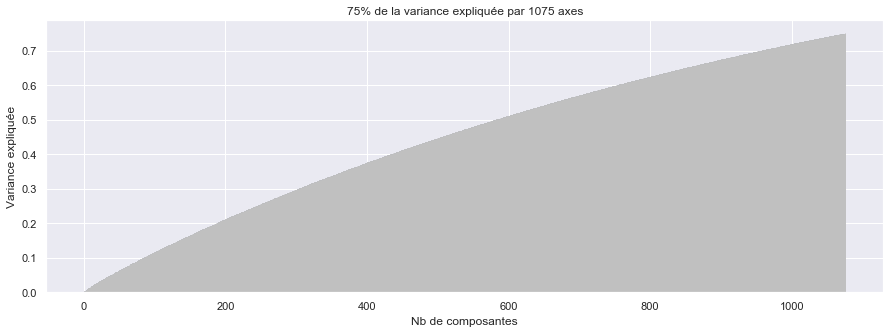

In [20]:
# STANDARDISATION:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X.values)

# REDUCTION by PCA: 75 % de variance expliquée                           
from sklearn import decomposition
pca = decomposition.PCA(n_components= 0.75,random_state = 33) 
X_pca = pca.fit_transform(X_scaled)

# Tracé de la variance expliquée par le nb de composantes:
plt.subplots(figsize=(15,5))
plt.bar(range(1,pca.explained_variance_ratio_.cumsum().shape[0]+1),
        pca.explained_variance_ratio_.cumsum(),
        edgecolor ='silver')
plt.xlabel('Nb de composantes')
plt.ylabel('Variance expliquée')
plt.title('75% de la variance expliquée par {} axes'.format(X_pca.shape[1]))
plt.show()

In [28]:
# K-means clustering:
Nb_cluster = 8
from sklearn.cluster import KMeans 
clust1 = KMeans(n_clusters=Nb_cluster,      
                init='k-means++',random_state=33).fit(X_pca)
df1 = pd.Series(clust1.labels_)
df2 = pd.DataFrame(df1.value_counts()).T
df2.index = ['nb_elements_par_cluster']
df2.columns = ['cluster%.0f'%x for x in range(1,Nb_cluster+1)]
df2

# Plus de 8 clusters implique un groupe avec moins de 6 films.
# Groupes extremement heterogenes

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8
nb_elements_par_cluster,3106,1566,107,64,24,20,18,6


### Critique du clustering:
- clusters tres inegaux, maximiser le nombre de cluster implique beaucoup de cluster à 1 film
- distance entre film inconnu, un film tiré dans le cluster du film sélectionné pourrait de fait est plus proche du centroïde de ce cluster que du centroïde d'un autre cluster, cela dit 2 films sur les frontieres dans 2 clusters differents, peuvent etre plus proches en etant dans differents clusters.
- Pour améliorer on pourrait:
    - reduire le nombre de composantes permet d'avoir des clusters plus homogènes (et plus de clusters avec au moins 6 films) mais on perd beaucoup de variance expliquée.
    - faire des clusters par groupe de variables, clusters sur les 'genres', puis clusters sur les 'acteurs', etc. On pourrait s'interesser aux intersections de clusters. Modèle moins simple. 
    - faire du clustering sur certaines variables priorisées (ex: les genres) et ensuite enchaîner par du Nearest Neighbour, mais autant faire directement du Nearest Neighbour sans clustering (pour ne pas prioriser de feature)

## Nearest Neighbours

#### kNN_1, sans réduction:

In [29]:
# Splitting: Binary & Numerical features:
#   because title_year >> other features, and splitting gives better results than standardization 

X1 = X['title_year']
X2 = X.drop('title_year', axis=1)

In [30]:
def knn_1(ID):
    """ - Recommandation des 5 plus proches voisins du film sélectionné
          via Nearest Neighbours, metrique utilisée: distance euclidienne. 
        - 'imdb_score' et 'title_year' non utilisé """
    
    # Movie selected:
    index_selected = int(data[data['movie_id']==ID].index.values)
    row_number_selected = data.index.get_loc(index_selected)
    X_matrix = X2.values
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn1 = NearestNeighbors(metric = 'euclidean')
    knn1.fit(X_matrix)

    # Recommandations:
    result = knn1.kneighbors(X=X_matrix[row_number_selected].reshape(1,-1), 
                             n_neighbors=6, 
                             return_distance=True)
    row_numbers = result[1][0].tolist()                # Les film recommandés
    distances = result[0][0].tolist()                  # Leur distance par rapport au film cherché
    indices = data.iloc[row_numbers,:].index.tolist()  # Les index des films recommandés

    df = pd.concat([pd.DataFrame(distances, columns=['distance'], index=indices), # distances
                    data.iloc[row_numbers,:]],                                    # dataframe initial
                    axis=1)
    result = df.sort_values('distance').head(6).drop(index_selected)
    return result[['movie_title','title_year','movie_id']]

In [31]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 68646
knn_1(Movie_id_selected)

,movie_title,title_year,movie_id
4241,Mi America,2015,2460506
2837,The Godfather: Part II,1974,71562
4943,An American in Hollywood,2014,2125430
3411,Brooklyn Rules,2007,283503
3426,Swelter,2014,2112277


#### kNN_2, avec réduction

In [32]:
# STANDARDISATION:
from sklearn.preprocessing import StandardScaler
X2_scaled = StandardScaler().fit_transform(X2.values)

# REDUCTION by PCA: 75 % de variance expliquée                           
from sklearn import decomposition
pca = decomposition.PCA(n_components= 0.75,random_state = 33) 
X2_pca = pca.fit_transform(X2_scaled)

In [33]:
def knn_2(ID):
    """ - Recommandation des 5 plus proches voisins via Nearest Neighbours,
          avec réduction par PCA en conservant 75% de variance expliquée,
          et via distance euclidienne. 
        - 'imdb_score' non utilisé """
        
    # Input data:
    index_selected = int(data[data['movie_id']==ID].index.values)
    row_number_selected = data.index.get_loc(index_selected)
    X_matrix = X2_pca 
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn2 = NearestNeighbors(metric = 'euclidean')
    knn2.fit(X_matrix)

    # Recommandations:
    result = knn2.kneighbors(X=X_matrix[row_number_selected].reshape(1,-1), 
                           n_neighbors=6, 
                           return_distance=True)
    row_numbers = result[1][0].tolist()               # Les film recommandés
    distances = result[0][0].tolist()                 # Leur distance par rapport au film cherché
    indices = data.iloc[row_numbers,:].index.tolist() # Les index des films recommandés

    df = pd.concat([pd.DataFrame(distances, columns=['distance'], index=indices), # les distances aux recommandations
                    data[['movie_id','movie_title']].iloc[row_numbers,:]],        # dataframe initial
                    axis=1)
    result = df.sort_values('distance').head(6).drop(index_selected)
    return result[['movie_id','movie_title']]

In [34]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 68646
knn_2(Movie_id_selected)

##### Résultat plutôt mauvais à cause de la distance euclidienne et les vecteurs peu remplis

,movie_id,movie_title
2837,71562,The Godfather: Part II
1571,78788,Apocalypse Now
3187,1772288,Danny Collins
4263,286244,The Triplets of Belleville
3411,283503,Brooklyn Rules


#### kNN_3, similarité cosinus

In [35]:
def knn_3(ID):
    """ - Détermination des films voisins via K Nearest Neighbours,
          sans réduction, via similarité cosinus. 
        - Sélection des 5 plus proches voisins.
        - 'imdb_score' et 'title_year' non utilisés """

    # Input data:
    index_selected = int(data[data['movie_id']==ID].index.values)
    row_number_selected = data.index.get_loc(index_selected)
    # Split: Binary & Numerical features:
    X1 = X['title_year']
    X2 = X.drop('title_year', axis=1)
    X_matrix = X2.values
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn3 = NearestNeighbors(metric='cosine')
    knn3.fit(X_matrix)

    # Cosine similarity for binary vectors
    result = knn3.kneighbors(X = X_matrix[row_number_selected].reshape(1,-1), 
                             n_neighbors = data.shape[0],   # distance à tous les points
                             return_distance = True)
    row_numbers = result[1][0].tolist()                     # Les film recommandés
    distances = result[0][0].tolist()                       # Leur distance par rapport au film cherché
    indices = data.iloc[row_numbers,:].index.tolist()       # Les index des films recommandés
    df = pd.concat([pd.DataFrame(distances, columns=['distance'], index=indices), # les distances aux recommandations
                    data[['movie_id','movie_title']].iloc[row_numbers,:]],        # dataframe initial
                    axis=1)
    result = df.sort_values('distance').head(6).drop(index_selected)
    return result[['movie_id','movie_title']]

In [36]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 68646
knn_3(Movie_id_selected)

##### Meilleur résultats qu'avec la distance euclidienne.

,movie_id,movie_title
2837,71562,The Godfather: Part II
4241,2460506,Mi America
4943,2125430,An American in Hollywood
895,99674,The Godfather: Part III
1571,78788,Apocalypse Now


In [37]:
################################################################################################
##  Evaluation/Comparaison: distance euclidienne VS similarité Cosinus VS similarité jaccard  ##
################################################################################################

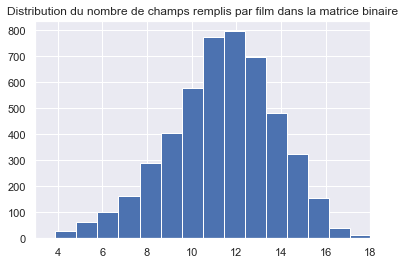

In [38]:
# Matrice binaire: un champ important peut-il être noyé parmi une multitude d'autres champs?
df = X2.T.sum()
plt.hist(df, bins=18)
plt.xlim([3,18])
plt.title('Distribution du nombre de champs remplis par film dans la matrice binaire')
plt.show()

In [39]:
# Nombre de mot-clefs maximum par film:
print( data['plot_keywords'].str.split('|').apply(len).max() )
# 5 max, reasonable

5


In [40]:
df.describe()
# ~11 champs remplis par film
# distribution ~apparemment normale ==> 95% des films ont entre 6 et 16 champs remplis

count    4911.000000
mean       11.405620
std         2.552823
min         2.000000
25%        10.000000
50%        12.000000
75%        13.000000
max        19.000000
dtype: float64

In [41]:
comparison = pd.concat([X.loc[2837,:],#[X.loc[2837,:]!=0],
                        X.loc[5036,:],#[X.loc[5036,:]!=0], 
                        X.loc[1906,:]],#[X.loc[1906,:]!=0]],
                        axis=1).drop(['title_year'])
comparison.columns = ['Godfather','Mongol King','Scarface']
comparison[(comparison!=0).any(axis=1)]

,Godfather,Mongol King,Scarface
actor_name_Al Pacino,1,0,1
actor_name_F. Murray Abraham,0,0,1
actor_name_Mary Elizabeth Mastrantonio,0,0,1
actor_name_Robert De Niro,1,0,0
actor_name_Robert Duvall,1,0,0
director_name_Brian De Palma,0,0,1
director_name_Francis Ford Coppola,1,0,0
genre_Crime,1,1,1
genre_Drama,1,1,1
color_Color,1,1,1


In [42]:
## Distance Euclidienne:  sqrt(sum((A_xi - B_xi)^2))

# Calcul des distances entre chaque points: A=Godfather, B=Mongol King, C=Scarface
AB_L2 = np.linalg.norm(comparison['Godfather']-comparison['Mongol King'])
AC_L2 = np.linalg.norm(comparison['Godfather']-comparison['Scarface'])
print('Distance Euclidienne [Godfather','Mongol King] :', round(AB_L2,2))
print('Distance Euclidienne [Godfather','Scarface] :', round(AC_L2,2))

Distance Euclidienne [Godfather Mongol King] : 2.83
Distance Euclidienne [Godfather Scarface] : 3.0


#### Critique distance euclidienne:
Ici le calcul donne 'Mongol King' plus proche de 'Godfather' que 'Scarface'. Alors que 'Scarface' a plus d'éléments en commun! 
- un film avec beaucoup de colonnes remplis (ex:mot-clefs) obtient beaucoup de colonnes à 1 ce qui l'éloigne du film recherché.
- Les champs vides en commun de 2 films sont comptés comme des similarités, alors que ça n'est pas un signe de similarité.


In [43]:
## Similarité Cosinus: |A n B| / ||A||.||B||

#   Le nombre de 1 en communs par feature:
AnB = comparison.loc[:,['Godfather','Mongol King']][(comparison.loc[:,['Godfather','Mongol King']]==1).all(axis=1)].shape[0]
AnC = comparison.loc[:,['Godfather','Scarface']][(comparison.loc[:,['Godfather','Scarface']]==1).all(axis=1)].shape[0]

# Produit des normes euclidiennes des vecteurs (Frobenius)
norm_A = np.linalg.norm(comparison['Godfather'])
norm_B = np.linalg.norm(comparison['Mongol King'])
norm_C = np.linalg.norm(comparison['Scarface'])

# Similarité cosinus:
cosine_AB = AnB/(norm_A*norm_B)
cosine_AC = AnC/(norm_A*norm_C)
print('Similarité Cosinus [Godfather','Mongol King] :', round(cosine_AB,2))
print('Similarité Cosinus [Godfather','Scarface] :', round(cosine_AC,2))

# Rappel: 2 vecteurs avec le même angle, donc très similaire, ont un coefficient de 1

Similarité Cosinus [Godfather Mongol King] : 0.59
Similarité Cosinus [Godfather Scarface] : 0.61


#### Critique similarité cosinus: 
La similarité [Godfather - Scarface] est plus proche de 1 que [Godfather - Mongol King]. Cette similarité donne Scarface plus proche de Godfather que Mongol King (c'est sérré, à 1% près).

Mieux que la distance Euclidienne mais le dénominateur dépend du nombre d'items = 1.
Pour cette raison les vecteurs plutôt vides sont toujours avantagés au détriment de ceux plus remplis.


In [44]:
## Similarité Jaccard: |A n B| / |A u B|
# The ratio of the number of properties that both vectors have in common, divided by the number of properties that at least one bond has. 

#   Numérateur: A n B: Le nombre de 1 en communs:
AnB = comparison.loc[:,['Godfather','Mongol King']][(comparison.loc[:,['Godfather','Mongol King']]==1).all(axis=1)].shape[0]
AnC = comparison.loc[:,['Godfather','Scarface']][(comparison.loc[:,['Godfather','Scarface']]==1).all(axis=1)].shape[0]

# Dénominateur: A u B =  A + B - A n B
A = comparison['Godfather'][comparison['Godfather']!=0].count() #Nb de features non nulles
B = comparison['Mongol King'][comparison['Mongol King']!=0].count()
C = comparison['Scarface'][comparison['Scarface']!=0].count()

# Similarité Jaccard:
jaccard_AB = AnB / (A + B - AnB)
jaccard_AC = AnC / (A + C - AnC)
print('Similarité Jaccard [Godfather','Mongol King] :', round(jaccard_AB,2))
print('Similarité Jaccard [Godfather','Scarface] :', round(jaccard_AC,2))

Similarité Jaccard [Godfather Mongol King] : 0.38
Similarité Jaccard [Godfather Scarface] : 0.44


#### Critique similarité jaccard:
La similarité [Godfather - Scarface] est plus proche de 1 que [Godfather - Mongol King].
L'écart entre les vecteurs est plus grand qu'avec la similarité cosinus: 5% 

En divisant par l'union des 2 vecteurs, l'avantage des vecteurs vides par rapport aux vecteurs remplis est encore amoindri par rapport à la similarité cosinus sans être nul toutefois.


In [689]:
################################################################################################
# Conclusion: choix de la métrique: Jaccard
################################################################################################

#### kNN_4, similarité jaccard

In [45]:
def knn_4(ID):
    """ - Détermination des films voisins via k Nearest Neighbours, sans réduction,
          via calcul de similarité jaccard sur matrice de features binaires
        - Sélection des 5 plus proches voisins.
        - 'imdb_score' et 'title_year' non utilisés """
        
    # Input data:
    index_selected = int(data[data['movie_id']==ID].index.values)
    row_number_selected = data.index.get_loc(index_selected)
    # Split: Binary & Numerical features:
    X1 = X['title_year']
    X2 = X.drop('title_year', axis=1)
    X_matrix = X2.values
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn4 = NearestNeighbors(metric='jaccard')
    knn4.fit(X_matrix)
    result = knn4.kneighbors(X = X_matrix[row_number_selected].reshape(1,-1), 
                             n_neighbors = 6,  
                             return_distance = True)
    row_numbers = result[1][0].tolist()                     # Les film recommandés
    distances = result[0][0].tolist()                       # Leur distance par rapport au film cherché
    indices = data.iloc[row_numbers,:].index.tolist()       # Les index des films recommandés
    df = pd.concat([pd.DataFrame(distances, columns=['distance'], index=indices), # les distances aux recommandations
                    data[['movie_id','movie_title']].iloc[row_numbers,:]],        # dataframe initial
                    axis=1)
    result = df.sort_values('distance').drop(index_selected)
    return result[['movie_id','movie_title']]

In [46]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 1232207
knn_4(Movie_id_selected)

,movie_id,movie_title
4338,850669,Slacker Uprising
4941,98213,Roger & Me
4241,2460506,Mi America
4187,2609912,Kevin Hart: Let Me Explain
4095,118541,8 Heads in a Duffel Bag


#### kNN_5 avec distances moyennes pondérées

In [47]:
def knn_5(ID):
    """ - Détermination des films voisins via k Nearest Neighbours, sans réduction,
          via calcul de similarité jaccard sur matrice de features binaires.
        - Calcul des distances sur matrice de features numériques.
        - Pondération entre distance et similarité pour déterminer les
          5 plus proches voisins. 
        - 'imdb_score' non utilisé """
    
    # Input data:
    index_selected = int(data[data['movie_id']==ID].index.values)
    row_number_selected = data.index.get_loc(index_selected)
    # Split: Binary & Numerical features:
    X1 = X['title_year']
    X2 = X.drop('title_year', axis=1)
    X_matrix = X2.values
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn5 = NearestNeighbors(metric='jaccard')
    knn5.fit(X_matrix)

    # Recommandation:
    result = knn5.kneighbors(X = X_matrix[row_number_selected].reshape(1,-1), 
                             n_neighbors = data.shape[0],   # distance à tous les points
                             return_distance = True)
    # Similarité - colonnes catégorielles:
    row_numbers = result[1][0].tolist()                 # Les film recommandés
    distances = result[0][0].tolist()                   # Leur distance par rapport au film cherché
    indices = data.iloc[row_numbers,:].index.tolist()   # Les index des films recommandés
    df_categories = pd.DataFrame(distances, index=indices, columns=['distance'])
    dtemp = pd.concat([df_categories, data], axis=1)

    # Distance - colonne numérique
    df_year = np.abs(X1-data['title_year'].iloc[row_number_selected]).sort_values()
    df_year.name = 'Numerical distance'

    # Distance finale: moyenne pondérée
    df_dist = pd.concat([df_year, df_categories], axis=1)
    df_dist.columns=['Numerical distance','Categorical distance']
    a = 0.002  # % choisi apres plusieurs itérations manuelles
    df_dist['Final_dist'] = a*df_dist['Numerical distance'] + (1-a)*df_dist['Categorical distance'] 

    dtemp = pd.concat([df_dist, data[['movie_title','movie_id']]], axis=1)
    dtemp = dtemp.sort_values('Final_dist').drop(index_selected) # Sélection 5 + proches voisins
    return dtemp[['movie_id','movie_title']].head()

In [48]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 1232207
knn_5(Movie_id_selected)

,movie_id,movie_title
4338,850669,Slacker Uprising
4941,98213,Roger & Me
4678,1999192,Kevin Hart: Laugh at My Pain
4586,854678,Taxi to the Dark Side
4187,2609912,Kevin Hart: Let Me Explain


#### kNN_6 distances moyennes pondérées + filtre fuzzy wuzzy + tri via imdb_score

In [49]:
def knn_6(ID):
    """ - Détermination des films voisins via k Nearest Neighbours, sans réduction,
          via calcul de similarité jaccard sur matrice de features binaires.
        - Calcul des distances sur matrice de features numériques.
        - Pondération entre distance et similarité pour déterminer les 15 plus proches voisins. 
        - Filtre sur les sagas/trilogies pour en conserver maximum 2.
        - Tri parmi la sélection de voisins via imdb_score décroissant
          pour sélectionner les 5 'meilleures' recommandations finales"""
    
    # Input data:
    index_selected = int(data[data['movie_id']==ID].index.values)
    row_number_selected = data.index.get_loc(index_selected)
    # Split: Binary & Numerical features:
    X1 = X['title_year']
    X2 = X.drop('title_year', axis=1)
    X_matrix = X2.values
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn6 = NearestNeighbors(metric='jaccard')
    knn6.fit(X_matrix)

    # Recommandation:
    result = knn6.kneighbors(X = X_matrix[row_number_selected].reshape(1,-1), 
                             n_neighbors = data.shape[0],   # distance à tous les points
                             return_distance = True)
    # Similarité - colonnes catégorielles:
    row_numbers = result[1][0].tolist()                 # Les film recommandés
    distances = result[0][0].tolist()                   # Leur distance par rapport au film cherché
    indices = data.iloc[row_numbers,:].index.tolist()   # Les index des films recommandés
    df_categories = pd.DataFrame(distances, index=indices, columns=['distance'])
    dtemp = pd.concat([df_categories, data], axis=1)

    # Distance - colonne numérique
    df_year = np.abs(X1-data['title_year'].iloc[row_number_selected]).sort_values()
    df_year.name = 'Numerical distance'

    # Distance finale: moyenne pondérée
    df_dist = pd.concat([df_year, df_categories], axis=1)
    df_dist.columns=['Numerical distance','Categorical distance']
    a = 0.002  # % choisi apres plusieurs itérations manuelles
    df_dist['Final_dist'] = a*df_dist['Numerical distance'] + (1-a)*df_dist['Categorical distance'] 

    dtemp = pd.concat([df_dist, data[['movie_title','movie_id']]], axis=1)
    dtemp = dtemp.sort_values('Final_dist').drop(index_selected) 
    dtemp = dtemp[['movie_id','movie_title']].head(15) # Sélection 15 + proches voisins

    # FILTRE si prequel/sequel/saga: via fuzzy woozy
    L_index = list(dtemp.index)
    L_names = list(dtemp.loc[:,'movie_title'])
    # Similarité entre les recommandations:
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    for film in L_names:
        L_films = L_names.copy()
        L_films.remove(film)
        # the score is measured in terms of the number of primitive operations
        # necessary to  convert the string into an exact match
        similar_movies = process.extract(film,    # 1 voisin        
                                         L_films, # 14 autres voisins
                                         limit=20,
                                         scorer=fuzz.token_set_ratio) # type of scorer
        df = pd.DataFrame(similar_movies, columns=['movie_title','similarity'])
        seuil_similarite = 70  # choisi apres plusieurs itérations manuelles
        saga = list(df['movie_title'][df['similarity']>=seuil_similarite])
        if len(saga)>1:          # Si trilogie
            L_names.remove(film) # filtre
            dtemp = dtemp[dtemp['movie_title']!=film]
    
    # TRI: via imdb_score parmi les + proches voisins
    dtemp.loc[dtemp.index, 'imdb_score'] = data.loc[dtemp.index,'imdb_score']
    dtemp = dtemp.sort_values('imdb_score', ascending=False)
    return dtemp[['movie_title','imdb_score']].head()

In [50]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 283900
knn_6(Movie_id_selected)

,movie_title,imdb_score
4263,The Triplets of Belleville,7.8
504,Oceans,7.8
4039,The Class,7.5
2876,"Paris, je t'aime",7.3
2879,The Widow of Saint-Pierre,7.3


#### Autre idée d'amélioration: 
- travailler sur les mot-clefs:
    - 'Catwoman' plot_keyword: *'based on cult comic book'*
    - 'Batman','Superman','Deadpool', etc. plot_keyword: *'based on comic book'*

Lorsqu'il y a plusieurs mots, ne pas chercher une concordance exact.
- Chercher les groupes principaux de mot-clefs: via fuzzy woozy levenshtein similarity
- Puis homogénéiser les données

E.g.: "based on comic book", "comic book", "comics", "based on cult comic book", "dc comics", etc.

In [51]:
data[['movie_title','plot_keywords','imdb_score']][data['movie_title'].str.contains('Catwoman')]

,movie_title,plot_keywords,imdb_score
313,Catwoman,based on cult comic book|bechdel test passed|c...,3.3


In [52]:
data[['movie_title','plot_keywords','imdb_score']][data['plot_keywords'].str.contains('comics')]

,movie_title,plot_keywords,imdb_score
66,The Dark Knight,based on comic book|dc comics|psychopath|star ...,9.0
239,The Wolverine,healing power|marvel comics|mecha|regeneration...,6.7
441,Batman Returns,box office hit|dc comics|gotham|mayor|penguin,7.0
537,Constantine,based on comic|based on comic book|dc arrowver...,7.5
1229,Spawn,based on comic|based on comic book|dark hero|i...,5.2
1400,Batman,city|dc comics|gotham|pantyhose|police,7.6
2518,Superman IV: The Quest for Peace,box office flop|dc comics|hair|nuclear disarma...,3.6
4265,American Splendor,1980s|comic book|dark horse comics|reference t...,7.5
4457,Batman: The Movie,black cat|catwoman|dc comics|penguin|riddler,6.5
4994,The Image Revolution,comic book|comic book history|comics|spawn|wal...,7.4


In [698]:
# Rappel: nomnbre de mot-clefs retenus

len(mask_kw)

785

In [699]:
# Filtre sur les groupes de mots uniquement:

mask_kw = list(pd.Series(mask_kw)[pd.Series(mask_kw).str.split(' ').apply(len)>1])
df = pd.Series(mask_kw).str.strip()
df_simil = pd.DataFrame(index=mask_kw)
len(mask_kw)

189

In [700]:
# Calcul similarité:
for string in df:
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    similar_kw = process.extract(string,                      # Nom en entrée
                                 mask_kw,                     # liste de mots à comparer
                                 limit=1274,
                                 scorer=fuzz.token_set_ratio) # type of scorer
    dtemp = pd.DataFrame(similar_kw)
    dtemp.columns = ['kw', string]
    dtemp = dtemp.set_index('kw', drop=True)
    dtemp.loc[string,string] = -1
    df_simil[string] = dtemp[string]

# Suppr. triangle inférieur matrice:
df = df_simil.where(np.triu(np.ones(df_simil.shape)).astype(np.bool))
# Stacking:
df = df.stack().reset_index()

df.columns = ['Row','Column','Similarité']
df = df[df['Similarité']>80]
df.head(10)

,Row,Column,Similarité
10,new york city,new york,100.0
69,new york city,manhattan new york city,100.0
755,female nudity,male nudity,92.0
767,female nudity,female frontal nudity,100.0
800,female nudity,female rear nudity,100.0
860,female nudity,topless female nudity,100.0
864,female nudity,female full frontal nudity,100.0
955,box office flop,box office hit,83.0
1670,male nudity,male frontal nudity,100.0
1687,male nudity,male rear nudity,100.0


#### Conclusion:
- On a des groupes de mots similaires qui s'opposent: [box office flop, box office hit], etc.
- Cela necessiterait travail manuel 

#### Autre idée d'amélioration: 
- Filtrer les vecteurs étant peu remplis faussant quelque peu la similarité: 

Example: 
- A = (1,1,1,1,0,0,0,0,0,0)
- B = (1,0,0,0,0,0,0,0,0,0)
- C = (1,1,1,1,1,1,1,1,1,1)

- Distance Euclidienne plus faible (similarité Cosinus / Jaccard plus forte)  entre A et B 
- Distance Euclidienne plus forte  (similarité Cosinus / Jaccard plus faible) entre A et C  
- Alors que A et C ont plus d'éléments en commun que A et B
- car les 0 ne sont pas tellement indicatif de similarité mais plutôt d'absence d'information dans le cas des vecteurs quasi-vides.

#### kNN_7 même chose qu'avant avec filtre sur les films peu remplis

In [53]:
def knn_7(ID):
    """ Idem knn_6 avec:
        - filtre sur vecteurs ayant moins de 7 features remplies dans la matrice des films
        - et sélection de 10 + proches voisins"""

    X1 = X['title_year']
    X2 = X.drop('title_year', axis=1)
    # Filtre vecteurs peu remplis:
    df = data[data['plot_keywords'].str.len()<1]           # Mot-clefs vides
    df2 = X2.loc[df.index,:][X2.loc[df.index,:].T.sum()<7] # maximum 6 colonnes remplies
    data_new = data.drop(df2.index)                        # suppression 97 films
    X_new = X.drop(df2.index)
    X1_new = X_new['title_year']
    X2_new = X_new.drop('title_year', axis=1)
    
    # Input data:
    index_selected = int(data_new[data_new['movie_id']==ID].index.values)
    row_number_selected = data_new.index.get_loc(index_selected)
    X_matrix = X2_new.values
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn7 = NearestNeighbors(metric='jaccard')
    knn7.fit(X_matrix)

    # Recommandation:
    result = knn7.kneighbors(X = X_matrix[row_number_selected].reshape(1,-1), 
                             n_neighbors = data_new.shape[0],   # distance à tous les points
                             return_distance = True)
    # Similarité - colonnes catégorielles:
    row_numbers = result[1][0].tolist()                 # Les film recommandés
    distances = result[0][0].tolist()                   # Leur distance par rapport au film cherché
    indices = data_new.iloc[row_numbers,:].index.tolist()   # Les index des films recommandés
    df_categories = pd.DataFrame(distances, index=indices, columns=['distance'])
    dtemp = pd.concat([df_categories, data_new], axis=1)

    # Distance - colonne numérique
    df_year = np.abs(X1_new-data_new['title_year'].iloc[row_number_selected]).sort_values()
    df_year.name = 'Numerical distance'

    # Distance finale: moyenne pondérée
    df_dist = pd.concat([df_year, df_categories], axis=1)
    df_dist.columns=['Numerical distance','Categorical distance']
    a = 0.002  # % choisi apres plusieurs itérations manuelles
    df_dist['Final_dist'] = a*df_dist['Numerical distance'] + (1-a)*df_dist['Categorical distance'] 

    dtemp = pd.concat([df_dist, data_new[['movie_title','movie_id']]], axis=1)
    dtemp = dtemp.sort_values('Final_dist').drop(index_selected) 
    dtemp = dtemp[['movie_id','movie_title']].head(10) # Sélection 15 + proches voisins

    # FILTRE si prequel/sequel/saga: via fuzzy woozy
    L_index = list(dtemp.index)
    L_names = list(dtemp.loc[:,'movie_title'])
    # Similarité entre les recommandations:
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    for film in L_names:
        L_films = L_names.copy()
        L_films.remove(film)
        # the score is measured in terms of the number of primitive operations
        # necessary to  convert the string into an exact match
        similar_movies = process.extract(film,    # 1 voisin        
                                         L_films, # 14 autres voisins
                                         limit=20,
                                         scorer=fuzz.token_set_ratio) # type of scorer
        df = pd.DataFrame(similar_movies, columns=['movie_title','similarity'])
        seuil_similarite = 70  # choisi apres plusieurs itérations manuelles
        saga = list(df['movie_title'][df['similarity']>=seuil_similarite])
        if len(saga)>1:          # Si trilogie
            L_names.remove(film) # filtre
            dtemp = dtemp[dtemp['movie_title']!=film]
    
    # TRI: via imdb_score parmi les + proches voisins
    dtemp.loc[dtemp.index, 'imdb_score'] = data_new.loc[dtemp.index,'imdb_score']
    dtemp = dtemp.sort_values('imdb_score', ascending=False)
    return dtemp[['movie_title','movie_id']].head()

In [54]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 68646
knn_7(Movie_id_selected)

,movie_title,movie_id
2837,The Godfather: Part II,71562
1571,Apocalypse Now,78788
1906,Scarface,86250
2180,The French Connection,67116
2900,Glengarry Glen Ross,104348


#### Conclusion:
Les vecteurs quasi vides supprimés permettent de faire apparaitre d'autres films.

Cela dit apparaissent en premiers les films ayant le meilleur imdb_score et non pas les plus proches voisins.
- On peut diminuer le nombre de voisin à considérer, mais dans le cas de StarWars on a 4 films de la saga à supprimer: il faut au moins 10 voisins.
- Ou bien au lieu de faire un tri sur le imdb_score, on garde le tri sur les similarités et on fait un filtre pour supprimer les films avec un imdb_score trop faible.

#### knn_8 : même chose qu'avant, mais filtre sur seuil minimum et non tri sur la notation:

In [55]:
def knn_8(ID):
    """ Idem knn_7 mais avec:
        - Suppression des films avec 'imdb_score' < 6 parmi
          les 15 plus proches voisins
        - Affichage des 5 recommandations par tri sur les distance/similarité"""

#     X1 = X['title_year']
#     X2 = X.drop('title_year', axis=1)

    # Filtre vecteurs peu remplis:
    df = data[data['plot_keywords'].str.len()<1]           # Mot-clefs vides
    df2 = X2.loc[df.index,:][X2.loc[df.index,:].T.sum()<7] # maximum 6 colonnes remplies
    data_new = data.drop(df2.index)                        # suppression 97 films
    X_new = X.drop(df2.index)
    X1_new = X_new['title_year']
    X2_new = X_new.drop('title_year', axis=1)
    
    # Input data:
    index_selected = int(data_new[data_new['movie_id']==ID].index.values)
    row_number_selected = data_new.index.get_loc(index_selected)
    X_matrix = X2_new.values
    
    # Unsupervised k Nearest Neighbours:
    from sklearn.neighbors import NearestNeighbors
    knn8 = NearestNeighbors(metric='jaccard')
    knn8.fit(X_matrix)

    # Recommandation:
    result = knn8.kneighbors(X = X_matrix[row_number_selected].reshape(1,-1), 
                             n_neighbors = data_new.shape[0],   # distance à tous les points
                             return_distance = True)
    # Similarité - colonnes catégorielles:
    row_numbers = result[1][0].tolist()                 # Les film recommandés
    distances = result[0][0].tolist()                   # Leur distance par rapport au film cherché
    indices = data_new.iloc[row_numbers,:].index.tolist()   # Les index des films recommandés
    df_categories = pd.DataFrame(distances, index=indices, columns=['distance'])
    dtemp = pd.concat([df_categories, data_new], axis=1)
 
    # Distance - colonne numérique
    df_year = np.abs(X1_new-data_new['title_year'].iloc[row_number_selected]).sort_values()
    df_year.name = 'Numerical distance'

    # Distance finale: moyenne pondérée
    df_dist = pd.concat([df_year, df_categories], axis=1)
    df_dist.columns=['Numerical distance','Categorical distance']
    a = 0.002  # % choisi apres plusieurs itérations manuelles
    df_dist['Final_dist'] = a*df_dist['Numerical distance'] + (1-a)*df_dist['Categorical distance'] 

    # TRI: sur la distance
    dtemp = pd.concat([df_dist, data_new[['movie_title','movie_id']]], axis=1)
    dtemp = dtemp.sort_values('Final_dist').drop(index_selected) 
    dtemp = dtemp[['movie_id','movie_title']].head(20) # Sélection 20 + proches voisins

    # FILTRE si prequel/sequel/saga: via fuzzy woozy
    L_index = list(dtemp.index)
    L_names = list(dtemp.loc[:,'movie_title'])
    # Similarité entre les recommandations:
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    for film in L_names:
        L_films = L_names.copy()
        L_films.remove(film)
        # the score is measured in terms of the number of primitive operations
        # necessary to  convert the string into an exact match
        similar_movies = process.extract(film,    # 1 voisin        
                                         L_films, # autres voisins
                                         limit=20,
                                         scorer=fuzz.token_set_ratio) # type of scorer
        df = pd.DataFrame(similar_movies, columns=['movie_title','similarity'])
        seuil_similarite = 70  # choisi apres plusieurs itérations manuelles
        saga = list(df['movie_title'][df['similarity']>=seuil_similarite])
        if len(saga)>1:          # Si trilogie
            L_names.remove(film) # filtre
            dtemp = dtemp[dtemp['movie_title']!=film]
    
    ## FILTRE: via imdb_score
    dtemp.loc[dtemp.index, 'imdb_score'] = data_new.loc[dtemp.index,'imdb_score']
    seuil = 6 # Note minimale
    dtemp = dtemp[dtemp['imdb_score']>seuil]
    
    return dtemp[['movie_title','movie_id']].head()

In [56]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 1232207
knn_8(Movie_id_selected)

,movie_title,movie_id
4941,Roger & Me,98213
4678,Kevin Hart: Laugh at My Pain,1999192
4586,Taxi to the Dark Side,854678
4187,Kevin Hart: Let Me Explain,2609912
4637,Food Chains,2141739


#### FINAL engine

In [57]:
def recommend_me(ID):
    """ In: A movie ID (from imdb_id)
        Out: 5 movies recommendation based on the entry"""

    ### Testing if ID among data: ###
    flag =1
    for x in data['movie_id']:
        if x==ID:
            flag=0
    if flag:
        return [{'Error':'The movie ID you entered is not in our database.'}]

    ### kNN: sélection 25 voisins: ###
    # Filtre champs: 'content_rating'
    L_kw_filter = []
    for string in X.columns: # content_rating & color not included:
        if (('plot_keywords_' not in string) and ('genre_' not in string)
            and ('actor_name_' not in string) and ('director_name_' not in string)
            and ('country_' not in string) and ('language_' not in string)
            and ('color' not in string)):
            L_kw_filter.append(string)
    X_genres = X.drop(L_kw_filter, axis=1)

    # Filtre observations peu remplies: ~149 lignes
    df = data[data['plot_keywords'].str.len()<1]
    X_genres = X_genres.drop(df.index) # Matrice binaire
    data_genres = data.loc[X_genres.index,:] # Matrice initiale correspondante

    # Input data:
    index_selected = int(data_genres[data_genres['movie_id']==ID].index.values)
    row_number_selected = data_genres.index.get_loc(index_selected)
    X_matrix = X_genres.values

    # FILTRE 25 plus proches voisins
    n_voisins = 25
    from sklearn.neighbors import NearestNeighbors
    knn = NearestNeighbors(metric='jaccard')
    knn.fit(X_matrix)
    result = knn.kneighbors(X = X_matrix[row_number_selected].reshape(1,-1),
                             n_neighbors = n_voisins,
                             return_distance = True)
    row_numbers = result[1][0].tolist()                      # Les films recommandés
    indices = data_genres.iloc[row_numbers,:].index.tolist() # Leurs index
    distances = result[0][0].tolist()                        # Leurs distances
    df_categories = pd.DataFrame(distances, index=indices, columns=['distance'])
    dtemp = pd.concat([df_categories, data.loc[indices,['movie_title','movie_id']]], axis=1).sort_values('distance')
    dtemp = dtemp.drop(index_selected) # suppression film recherché des recommandations

#     FILTRE si prequel/sequel/saga: via fuzzy woozy
    L_names = list(dtemp.loc[:,'movie_title'])
    # Similarité entre les recommandations:
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    for film in L_names:
        L_films = L_names.copy()
        L_films.remove(film)
        # the score is measured in terms of the number of primitive operations
        # necessary to  convert the string into an exact match
        similar_movies = process.extract(film,    # 1 voisin
                                         L_films, # autres voisins
                                         limit=25,
                                         scorer=fuzz.token_set_ratio) # type of scorer
        df = pd.DataFrame(similar_movies, columns=['movie_title','similarity'])
        seuil_similarite = 70  # choisi apres plusieurs itérations manuelles
        saga = list(df['movie_title'][df['similarity']>=seuil_similarite])
        if len(saga)>2:     # Si trilogie ou saga - on ne garde que les 2 les + proches
            flag = 0
            df = dtemp.sort_values('distance')
            for index, row in df.iterrows():
                if row['movie_title'] in saga:
                    if flag<2:
                        flag += 1
                    else:
                        dtemp = dtemp.drop(index)
    indices = dtemp.index
 
    # Distance - colonne numérique
    df_year = np.abs( X.loc[indices,'title_year'] -data.loc[index_selected,'title_year']).sort_values()
    df_year.name = 'Numerical distance'
    
    # Distance finale: moyenne pondérée
    df_dist = pd.concat([df_year, df_categories], axis=1)
    df_dist.columns=['Numerical distance','Categorical distance']
    a = 0.002  # % choisi apres plusieurs itérations manuelles
    df_dist['Final_dist'] = a*df_dist['Numerical distance'] + (1-a)*df_dist['Categorical distance']

    # TRI: sur la distance et FILTRE 15 plus proches voisins
    dtemp = pd.concat([df_dist, data.loc[indices,['movie_title','movie_id']]], axis=1)
    dtemp = dtemp.sort_values('Final_dist')

    dtemp = dtemp[['movie_id','movie_title']].head(15) # Sélection 15 plus proches voisins

    ## TRI: via imdb_score et FILTRE 5 plus proches voisins
    dtemp.loc[dtemp.index, 'imdb_score'] = data.loc[dtemp.index,'imdb_score']
    dtemp = dtemp.sort_values('imdb_score', ascending=False)

    # Résultat:
    return dtemp[['movie_title','movie_id']].head()


In [58]:
# Choix de film utilisateur & recommandation:
Movie_id_selected = 188674
recommend_me(Movie_id_selected)

,movie_title,movie_id
2219,High Fidelity,146882.0
1037,Pirate Radio,1131729.0
4300,It's All Gone Pete Tong,388139.0
3399,Another Year,1431181.0
3984,The Full Monty,119164.0


### Evaluation/quantification de la performance de la recommandation: 
- Créer un échantillon de films test & évaluer: notation /5
- Normalement réalisé par les utilisateurs


In [59]:
# Test Sample: For performance evaluation of the recommendation

selection_idx = {} # name:id

## Selection of eclectic samples (not having user reviews)

# Crime|Drama classic:   
selection_idx['Godfather'] = 68646
# Sci-fy blockbuster et saga:  
selection_idx['Star Wars: Episode I - The Phantom Menace'] = 120915
# Documentary, 2009:  
selection_idx['Capitalism: A Love Story'] = 1232207
# French & Comedy & Romance & imdb=8.4  
selection_idx['Amelie'] = 211915
# Mandarin & Adventure & History & imdb=6.1 
selection_idx['Dragon Blade'] = 3672840
# Japanese & Anime & imdb=8.1
selection_idx['Spirited Away'] = 245429
# Italy, Western, 1966, imdb=8.9
selection_idx['The Good, the Bad and the Ugly'] = 60196
# Movie whose closest recommendations are a saga 
selection_idx['Return to Oz'] = 89908
# Quentin Tarantino, Bruce Willis, 1994
selection_idx['Pulp Fiction'] = 110912
# Wes Anderson movie:
selection_idx['The Grand Budapest Hotel'] = 2278388
# Sample selection:
selection_idx

{'Godfather': 68646,
 'Star Wars: Episode I - The Phantom Menace': 120915,
 'Capitalism: A Love Story': 1232207,
 'Amelie': 211915,
 'Dragon Blade': 3672840,
 'Spirited Away': 245429,
 'The Good, the Bad and the Ugly': 60196,
 'Return to Oz': 89908,
 'Pulp Fiction': 110912,
 'The Grand Budapest Hotel': 2278388}

In [60]:
# Recommandations engines example:

Movie_id_selected = 211915
df1 = knn_1(Movie_id_selected)['movie_title'].reset_index(drop=True)
df2 = knn_2(Movie_id_selected)['movie_title'].reset_index(drop=True)
df3 = knn_3(Movie_id_selected)['movie_title'].reset_index(drop=True)
df4 = knn_4(Movie_id_selected)['movie_title'].reset_index(drop=True)
df5 = knn_5(Movie_id_selected)['movie_title'].reset_index(drop=True)
df6 = knn_6(Movie_id_selected)['movie_title'].reset_index(drop=True)
df7 = knn_7(Movie_id_selected)['movie_title'].reset_index(drop=True)
df8 = knn_8(Movie_id_selected)['movie_title'].reset_index(drop=True)
df9 = recommend_me(Movie_id_selected)['movie_title'].reset_index(drop=True)
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9], axis=1)
df.columns = ['knn%i'%x for x in range(1,10)]
df

,knn1,knn2,knn3,knn4,knn5,knn6,knn7,knn8,knn9
0,Barbecue,A Very Long Engagement,When the Cat's Away,When the Cat's Away,When the Cat's Away,A Very Long Engagement,A Very Long Engagement,When the Cat's Away,The Artist
1,When the Cat's Away,Barbecue,The Names of Love,The Names of Love,The Names of Love,Frances Ha,"Paris, je t'aime",The Names of Love,A Very Long Engagement
2,Welcome to the Sticks,Asterix at the Olympic Games,Micmacs,Micmacs,Micmacs,"Paris, je t'aime",The Widow of Saint-Pierre,Micmacs,Molière
3,The Names of Love,The Case of the Grinning Cat,Welcome to the Sticks,Welcome to the Sticks,Welcome to the Sticks,L'auberge espagnole,L'auberge espagnole,Welcome to the Sticks,"Paris, je t'aime"
4,Les visiteurs,Molière,Barbecue,A Very Long Engagement,A Very Long Engagement,The Widow of Saint-Pierre,The Names of Love,A Very Long Engagement,L'auberge espagnole


In [61]:
# Evaluation utilisteur des recommandations:

# 1 point si le film est similaire et de bonne qualité (en terme de imdb_score)
# 0.5 point si le film est similaire mais de faible qualité
# 0.5 point si le film est assez similaire et de bonne qualité
# 0 point si le film n'est pas similaire ou de très mauvaise qualité
# -0.5 si le film est inaproprié (e.g. Horror for Anime)
# saga/trilogie: occurrences comptés seulement 2 fois max

df = pd.DataFrame(np.zeros((10,9), dtype=float))
df.index = [*selection_idx.keys()]
df.columns = ['kNN brut, euclidien',
              'kNN réduit, euclidien',
              'kNN binaire similarité cosinus',
              'kNN binaire similarité jaccard',
              'kNN selection et tri par distances moyennées',
              'kNN selection par distance moyennée + filtre saga + tri notation',
              'kNN selection par distance moyennée + filtre saga + tri notation + filtre points ~vides',
              'kNN tri par distance moyennée + filtre saga + filtre notation + filtre points ~vides',
              'kNN sans color et content_rating, et filtres affinés']
df.loc['Godfather',:] =                                 [3  ,1.5,2.5,3.5,3.5,3.5,3.5,4.5,4.5]
df.loc['Star Wars: Episode I - The Phantom Menace',:] = [2  ,2  ,2  ,2  ,2  ,2.5,2.5,3  ,4  ]
df.loc['Capitalism: A Love Story',:] =                  [1  ,4  ,3  ,2  ,4  ,4  ,4  ,3  ,4  ]
df.loc['Amelie',:] =                                    [1  ,2.5,3.5,4.5,4.5,4  ,4  ,4.5,5  ]
df.loc['Dragon Blade',:] =                              [1  ,4  ,5  ,5  ,5  ,4  ,4  ,5  ,5  ]
df.loc['Spirited Away',:] =                             [2.5,3.5,3.5,4  ,4  ,4  ,4  ,4  ,4.5]
df.loc['The Good, the Bad and the Ugly',:] =            [2  ,2.5,3  ,3  ,4.5,5  ,4.5,4.5,4.5]
df.loc['Return to Oz',:] =                              [0.5,1  ,3.5,3.5,3  ,3.5,4.5,3.5,3.5]
df.loc['Pulp Fiction',:] =                              [1  ,1  ,1.5,2.5,3  ,4  ,4  ,4  ,5  ]
df.loc['The Grand Budapest Hotel',:] =                  [0  ,3,  2,  2  ,4  ,4  ,5  ,5  ,5  ]
df

,"kNN brut, euclidien","kNN réduit, euclidien",kNN binaire similarité cosinus,kNN binaire similarité jaccard,kNN selection et tri par distances moyennées,kNN selection par distance moyennée + filtre saga + tri notation,kNN selection par distance moyennée + filtre saga + tri notation + filtre points ~vides,kNN tri par distance moyennée + filtre saga + filtre notation + filtre points ~vides,"kNN sans color et content_rating, et filtres affinés"
Godfather,3.0,1.5,2.5,3.5,3.5,3.5,3.5,4.5,4.5
Star Wars: Episode I - The Phantom Menace,2.0,2.0,2.0,2.0,2.0,2.5,2.5,3.0,4.0
Capitalism: A Love Story,1.0,4.0,3.0,2.0,4.0,4.0,4.0,3.0,4.0
Amelie,1.0,2.5,3.5,4.5,4.5,4.0,4.0,4.5,5.0
Dragon Blade,1.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0
Spirited Away,2.5,3.5,3.5,4.0,4.0,4.0,4.0,4.0,4.5
"The Good, the Bad and the Ugly",2.0,2.5,3.0,3.0,4.5,5.0,4.5,4.5,4.5
Return to Oz,0.5,1.0,3.5,3.5,3.0,3.5,4.5,3.5,3.5
Pulp Fiction,1.0,1.0,1.5,2.5,3.0,4.0,4.0,4.0,5.0
The Grand Budapest Hotel,0.0,3.0,2.0,2.0,4.0,4.0,5.0,5.0,5.0


#### Models evaluations:

In [711]:
df.mean()

kNN brut, euclidien                                                                        1.40
kNN réduit, euclidien                                                                      2.50
kNN binaire similarité cosinus                                                             2.95
kNN binaire similarité jaccard                                                             3.20
kNN selection et tri par distances moyennées                                               3.75
kNN selection par distance moyennée + filtre saga + tri notation                           3.85
kNN selection par distance moyennée + filtre saga + tri notation + filtre points ~vides    4.00
kNN tri par distance moyennée + filtre saga + filtre notation + filtre points ~vides       4.10
kNN sans color et content_rating, et filtres affinés                                       4.50
dtype: float64

Limites: 
- Champs 'mal' renseignés:
  - nécessite conventions de nommage (ex: 'Catwoman' not linked to other comics)
  - 'Kevin Hart' in documentary
  - 'Aliens' not in horror
  - Star Wars I: mot-clefs pas assez générique: 'martial arts|murdered before giving protagonist information|part computer animation|prequel|prequel to cult film'
  - Valeurs erronées: 'Destiny', 'Battlefield Earth': jeux videos
- Saga that cannot be filtered based on movie_title (ex: James Bond)

- La base de donnée est limité: pour 'Modern Times' il manque les autres films de Chaplin

- Evaluation personnelle et limitée, donc subjective, necessite beaucoup plus d'avis variés

- Prioriser les Genres et Mot-clefs ne suffit pas à capturer la similarité d'un film:
  - ajout de director_name - exemples frappant: Wes Anderson, Hayao Miyazaki, Cédric Klapisch, Sergio Leone.
  - ajout de country et language et nom d'acteurs. Cette priorisation est en fait un amoindrissement de l'importance des features sur 'color' et 'content_rating'